# DA-231 Project

## Comprehensive Stock Market Analyser

### Team members
+ Kumar Gaurav (kumarg@iisc.ac.in)
+ Vidya Venkappa (vidyav@iisc.ac.in)
+ Vansh Jain (vanshjain@iisc.ac.in)
+ Kumar Shubham (kumarshubham@iisc.ac.in)

### Initial PySpark Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install flair
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"


Mounted at /content/drive
     |████████████████████████████████| 322 kB 5.2 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 1.2 MB 43.1 MB/s 
     |████████████████████████████████| 788 kB 36.3 MB/s 
     |████████████████████████████████| 19.7 MB 1.2 MB/s 
     |████████████████████████████████| 61 kB 462 kB/s 
     |████████████████████████████████| 981 kB 38.9 MB/s 
     |████████████████████████████████| 3.3 MB 43.7 MB/s 
     |████████████████████████████████| 48 kB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 62 kB 831 kB/s 
     |████████████████████████████████| 895 kB 40.9 MB/s 
     |████████████████████████████████| 3.3 MB 40.9 MB/s 
     |████████████████████████████████| 596 kB 33.0 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=d9d280fb531f3f1acf2b

In [2]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

### Define dataset related constants here

In [14]:
NIFTY_50_dataset ="/content/drive/Shareddrives/da-231-project/dataset/SCRIP/NIFTY50_all.csv"
NIFTY_50_metadata="/content/drive/Shareddrives/da-231-project/dataset/SCRIP/stock_metadata.csv"

NIFTY_50_datasetq12 ="/content/drive/Shareddrives/da-231-project/NIFTY50_all.csv"
NIFTY_50_metadata1q12="/content/drive/Shareddrives/da-231-project/dataset/SCRIP/stock_metadata.csv"

__SCRIPS_DATASET__ = "/content/drive/Shareddrives/da-231-project/dataset/SCRIP/*.csv"

Nifty50_df = spark.read.option("header",True).option("inferSchema",True).csv(NIFTY_50_dataset)
meta_df = spark.read.option("header",True).option("inferSchema",True).csv(NIFTY_50_metadata)

Nifty50_df_q12 = spark.read.option("header",True).option("inferSchema",True).csv(NIFTY_50_datasetq12)
meta_df_q12 = spark.read.option("header",True).option("inferSchema",True).csv(NIFTY_50_metadata1q12)

__STOCKS_DF__ = spark.read.csv(__SCRIPS_DATASET__, header=True, inferSchema=True)
stock_df = spark.read.option("header",True).option("inferSchema",True).csv(__SCRIPS_DATASET__)

In [5]:
Nifty50_Master_Df=Nifty50_df_q12.join(meta_df_q12,Nifty50_df_q12["Symbol"]==meta_df_q12["Symbol"])\
.select(Nifty50_df_q12["Date"],Nifty50_df_q12["Symbol"],Nifty50_df_q12["Prev Close"],Nifty50_df_q12["Open"],Nifty50_df_q12["High"],\
        Nifty50_df_q12["Low"],Nifty50_df_q12["Close"],meta_df_q12["Company Name"],meta_df_q12["Industry"])
#Nifty50_df_q12.filter(Nifty50_df_q12["Symbol"]=="ULTRACEMCO").show()
#meta_df_q12.show()
Nifty50_Master_Df.show()

+----------+----------+----------+------+------+------+------+--------------------+--------+
|      Date|    Symbol|Prev Close|  Open|  High|   Low| Close|        Company Name|Industry|
+----------+----------+----------+------+------+------+------+--------------------+--------+
|2012-01-17|ADANIPORTS|     135.5| 137.1| 141.0| 135.0| 140.0|Adani Ports and S...|SERVICES|
|2012-01-18|ADANIPORTS|     140.0| 142.0| 143.8| 138.7| 141.7|Adani Ports and S...|SERVICES|
|2012-01-19|ADANIPORTS|     141.7| 144.0|150.55|143.15| 149.4|Adani Ports and S...|SERVICES|
|2012-01-20|ADANIPORTS|     149.4| 151.9| 157.6|150.25| 155.4|Adani Ports and S...|SERVICES|
|2012-01-23|ADANIPORTS|     155.4| 155.4| 155.4| 145.1|146.75|Adani Ports and S...|SERVICES|
|2012-01-24|ADANIPORTS|    146.75|147.05| 152.9| 145.6|150.05|Adani Ports and S...|SERVICES|
|2012-01-25|ADANIPORTS|    150.05|150.95|150.95|142.25| 143.2|Adani Ports and S...|SERVICES|
|2012-01-27|ADANIPORTS|     143.2| 145.8|149.65| 144.8| 147.1|Adani Po

In [6]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import when,weekofyear,year,month
from pyspark.sql import Window
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd 
from pyspark.sql.functions import dayofweek, year, lit,max, avg, count, col, when, ceil, substring, sum, length, split, abs, mean, unix_timestamp, to_date, desc, udf, to_date, date_format
from pyspark.sql.types import IntegerType
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from matplotlib.dates import MonthLocator, DateFormatter,YearLocator
from pyspark.sql.functions import to_timestamp,date_format,concat
from datetime import datetime
from pyspark.sql.functions import abs
from pyspark.sql.functions import min as sparkMin
from pyspark.sql.functions import max as sparkMax

In [7]:
#Twitter Sentiment Imports
from pyspark.sql.types import *
from pyspark.sql import Row
import flair, re
from datetime import datetime, timedelta
import time

sentiment_model = flair.models.TextClassifier.load('en-sentiment')
import requests

import bs4
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from pyspark.sql import SQLContext

2021-12-10 16:40:02,574 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpex9kpkok


100%|██████████| 265512723/265512723 [00:10<00:00, 24790658.47B/s]

2021-12-10 16:40:13,642 copying /tmp/tmpex9kpkok to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-12-10 16:40:14,315 removing temp file /tmp/tmpex9kpkok
2021-12-10 16:40:14,361 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
#Twitter Sentiment User Defined Functions 
def getData(tweet):
  data = {
    'id': tweet['id'],
    'created_at': tweet['created_at'],
    'text': tweet['text']
  }
  return data

#Function is used to clean the text of tweets
def clean(tweet):
  tweet = whitespace.sub(' ', tweet)
  tweet = web_address.sub('', tweet)
  tweet = reliance.sub('Reliance', tweet)
  tweet = user.sub('', tweet)
  return tweet

tweetUDF = udf(lambda z:clean(z),StringType())

#This function substracts 1 hour for date time
def time_travel(endTime, mins):
    endTime = datetime.strptime(endTime, dtformat)
    back_in_time = endTime - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)


In [9]:
#Festive season Data
seasonRange = {"Diwali":["10-25", "11-10"],
               "Holi": ["02-25","03-10"]}


##Problem 1. For a particular sector (example: Banking) show the stock (ex: HDFC) performance within a particular time frame

This is also known as the Beta value for a stock (a measure of volatility relative to a benchmark)

<Figure size 6400x1200 with 0 Axes>

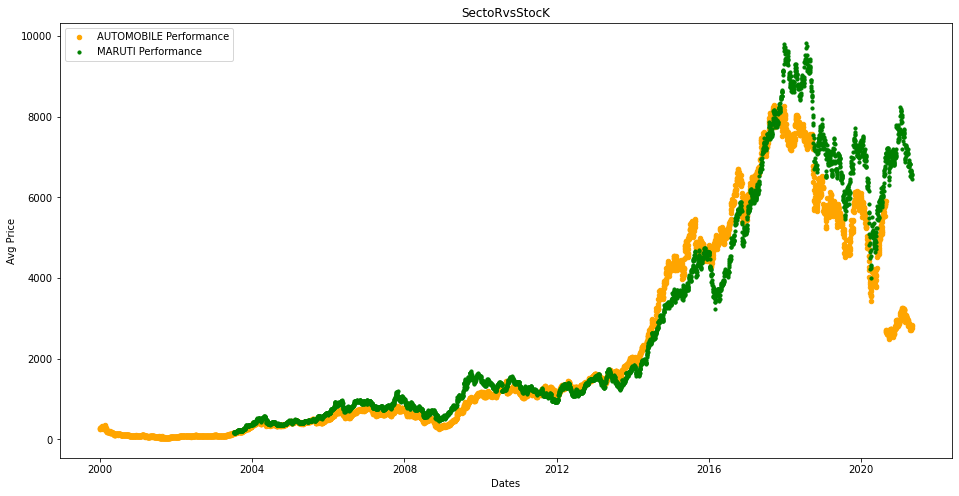

In [10]:
'''
sector (str) -> The sector relative to which we want to see the performance
stock_scrip (str) -> The stock market symbol for the company whose performance is to be measured
start_time (str) -> date in the given format - dd/mm/yyyy
end_time (str) -> date in the given format - dd/mm/yyyy
'''
def problemOne(sector, stock_scrip, start_time, end_time):
  # Write the code for your function here
  start_time = datetime.strptime(start_time,'%d/%m/%Y')
  end_time = datetime.strptime(end_time,'%d/%m/%Y')
  figure(figsize=(80, 15), dpi=80)
  Nifty50_Master_Df1=Nifty50_Master_Df.withColumn("Date",Nifty50_Master_Df.Date.cast('Date'))
  
  
  
  sector_df=(Nifty50_Master_Df1
    .where( (Nifty50_Master_Df1["Industry"]==sector) & (Nifty50_Master_Df1["Date"].between(start_time,end_time)) )
    .groupBy("Date")
    .agg(mean("close")))

  sector_pd_df=sector_df.toPandas()
  sector_data=sector_pd_df.set_index('Date')
  plt.figure(figsize=(16,8))
  plt.scatter(sector_data.index, sector_data["avg(close)"],color="orange",s=20,label=sector+" Performance")
  
  #Nifty50_Master_Df1.filter(Nifty50_Master_Df1["Symbol"]=="INFRATEL").show()
  stock_df=(Nifty50_Master_Df1
    .where( (Nifty50_Master_Df1["Symbol"]==stock_scrip) & (Nifty50_Master_Df1["Date"].between(start_time,end_time)) )
    .groupBy("Date")
    .agg(mean("close")))
  
  #stock_df.show()
  #print(Nifty50_Master_Df.select('Symbol').distinct().collect())
  stock_pd_df=stock_df.toPandas()
  stock_data=stock_pd_df.set_index('Date')
  plt.scatter(stock_data.index, stock_data["avg(close)"],color="green",s=10,label= stock_scrip+" Performance")
  plt.xlabel("Dates")
  plt.ylabel("Avg Price")
  plt.title("SectoRvsStocK")

 

   
  # sector_df.toPandas().to_excel('SectorOutput.xls', sheet_name = 'Sheet1', index = False)
  
  plt.legend()
  plt.show()
  
 



problemOne("AUTOMOBILE","MARUTI","03/01/2000","30/04/2021")


## Problem 2. For a particular sector, find out the most correlated other sector in the available list of sectors[link text](https://)
**Example**: Take "FINANCIAL SERVICES" sector as an input and show the sector having the maximum co-relation with it (E.g., CONSUMER GOODS_SECTOR)

{'CEMENT & CEMENT PRODUCTS_SECTOR_DF': 10.5773164129195, 'METALS_SECTOR_DF': 23.893345947192234, 'TELECOM_SECTOR_DF': 31.069054263348548, 'SERVICES_SECTOR_DF': 23.892192099197036, 'MEDIA & ENTERTAINMENT_SECTOR_DF': 18.73335505343661, 'CONSTRUCTION_SECTOR_DF': 21.493880878391025, 'ENERGY_SECTOR_DF': 19.26190214491328, 'AUTOMOBILE_SECTOR_DF': 15.165924870851322, 'FERTILISERS & PESTICIDES_SECTOR_DF': 19.968007760971144, 'IT_SECTOR_DF': 23.446154203911547, 'PHARMA_SECTOR_DF': 15.508515567263087, 'CONSUMER GOODS_SECTOR_DF': 8.850377849262589}
The Sector which is having maximum co-relation w.r.t. FINANCIAL SERVICES is :-CONSUMER GOODS_SECTOR_DF


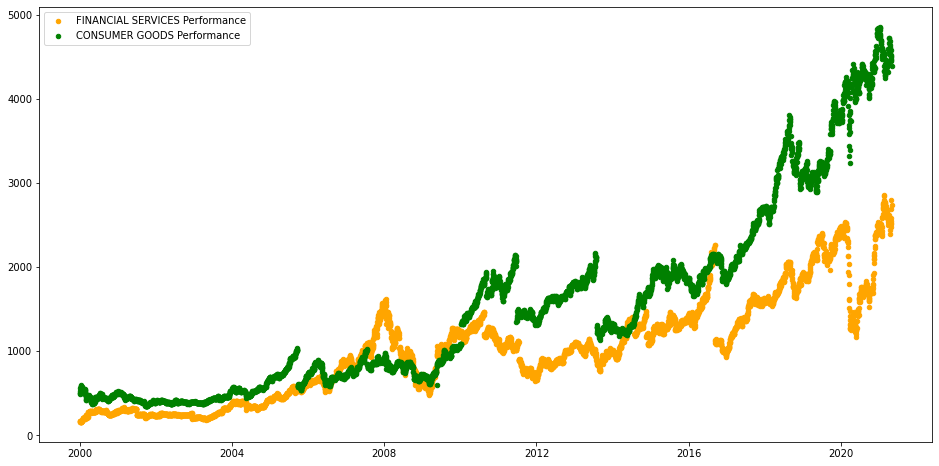

In [11]:
"""
sector (str) -> The sector for which we have to find out the most correlated sector
"""
def problemTwo(sector):
  Nifty50_Master_Df1=Nifty50_Master_Df.withColumn("Date",Nifty50_Master_Df.Date.cast('Date'))
  sector_input=sector
  sector_input_df=(Nifty50_Master_Df1
    .where( Nifty50_Master_Df1["Industry"]==sector )
    .groupBy("Date")
    .agg(mean("close")))
  # sector_input_df.show()
  sector_input_df=sector_input_df.withColumn("Daily_Avg_Close",sector_input_df["avg(close)"])
  sector_input_df=sector_input_df.drop("avg(close)")
  sector_input_df=sector_input_df.withColumn("Sector_Name",lit(sector))
  sector_input_df_min=sector_input_df.agg({'Daily_Avg_Close': 'min'})
  sector_input_df_Min_Daily_Avg_Close_value=sector_input_df_min.collect()[0][0]
  sector_input_df=sector_input_df.withColumn("Min_Daily_Avg_Close",lit(sector_input_df_Min_Daily_Avg_Close_value))
  sector_input_df_max=sector_input_df.agg({'Daily_Avg_Close': 'max'})
  sector_input_df_Max_Daily_Avg_Close_value=sector_input_df_max.collect()[0][0]
  sector_input_df=sector_input_df.withColumn("Max_Daily_Avg_Close",lit(sector_input_df_Max_Daily_Avg_Close_value))
  sector_input_df=sector_input_df.withColumn("Normalized_Dly_Avg_Close",\
                                       (sector_input_df["Daily_Avg_Close"]-sector_input_df["Min_Daily_Avg_Close"])*100 /(sector_input_df["Max_Daily_Avg_Close"]-sector_input_df["Min_Daily_Avg_Close"]))
  sector_input_pd_df=sector_input_df.toPandas()
  sector_input_data=sector_input_pd_df.set_index('Date')
  plt.figure(figsize=(16,8))
  plt.scatter(sector_input_data.index, sector_input_data["Daily_Avg_Close"],color="orange",s=20,label=sector_input+" Performance")
  
  

  sector_li=Nifty50_Master_Df1.select("Industry").where(Nifty50_Master_Df1["Industry"]!=sector).distinct()#.collect()
  AVG_RELATIVE_DIVERGENCE_DICT={}
  sector_list = [(row.Industry) for row in sector_li.collect()]
  for sector in sector_list:
      sector_itr=sector+"_SECTOR_DF"
      sector_itr_name=sector_itr
      #print(sector_itr)
      sector_itr=(Nifty50_Master_Df1
    .where( Nifty50_Master_Df1["Industry"]==sector )
    .groupBy("Date")
    .agg(mean("close")))
      sector_itr=sector_itr.withColumn("Sector_Name",lit(sector_itr_name))
      sector_itr=sector_itr.withColumn("Daily_Avg_Close",sector_itr["avg(close)"])
      sector_itr=sector_itr.drop("avg(close)")
      sector_itr_min=sector_itr.agg({'Daily_Avg_Close': 'min'})
      sector_itr_Min_Daily_Avg_Close_value=sector_itr_min.collect()[0][0]
      sector_itr=sector_itr.withColumn("Min_Daily_Avg_Close",lit(sector_itr_Min_Daily_Avg_Close_value))
      sector_itr_max=sector_itr.agg({'Daily_Avg_Close': 'max'})
      sector_itr_Max_Daily_Avg_Close_value=sector_itr_max.collect()[0][0]
      sector_itr=sector_itr.withColumn("Max_Daily_Avg_Close",lit(sector_itr_Max_Daily_Avg_Close_value))
      sector_itr=sector_itr.withColumn("Normalized_Dly_Avg_Close",\
                                       (sector_itr["Daily_Avg_Close"]-sector_itr["Min_Daily_Avg_Close"])*100 /(sector_itr["Max_Daily_Avg_Close"]-sector_itr["Min_Daily_Avg_Close"]))

      sector_itr_joined_input=sector_itr.join(sector_input_df,(sector_input_df["Date"]==sector_itr["Date"])).\
      select(sector_itr["Date"],sector_itr["Sector_Name"],sector_input_df["Sector_Name"],\
             sector_input_df["Normalized_Dly_Avg_Close"]-sector_itr["Normalized_Dly_Avg_Close"])
      sector_itr_joined_input=sector_itr_joined_input.withColumn("DAILY_DIVERGENCE",sector_itr_joined_input["(Normalized_Dly_Avg_Close - Normalized_Dly_Avg_Close)"])
      sector_itr_joined_input=sector_itr_joined_input.drop("(Normalized_Dly_Avg_Close - Normalized_Dly_Avg_Close)")
      sector_itr_joined_input=sector_itr_joined_input.withColumn("ABSOLUTE_DAILY_RELATIVE_DIVERGENCE_WITH_GIVEN_SECTOR",abs(sector_itr_joined_input["DAILY_DIVERGENCE"]))
      sector_itr_joined_input=sector_itr_joined_input.drop("DAILY_DIVERGENCE")
      sector_input_df_daily_divergence=sector_itr_joined_input.agg({'ABSOLUTE_DAILY_RELATIVE_DIVERGENCE_WITH_GIVEN_SECTOR': 'mean'})
      sector_input_df_daily_divergence_avg=sector_input_df_daily_divergence.collect()[0][0]
      
      AVG_RELATIVE_DIVERGENCE_DICT.update({sector_itr_name : sector_input_df_daily_divergence_avg})
      
      
      #sector_itr_joined_input.show(2) 
      #sector_itr.show(2)
  # sector_input_df.show()
  
  print(AVG_RELATIVE_DIVERGENCE_DICT)
  
  min_avg_divergence = min(AVG_RELATIVE_DIVERGENCE_DICT.values())
  
  cor_sector = [key for key in AVG_RELATIVE_DIVERGENCE_DICT if AVG_RELATIVE_DIVERGENCE_DICT[key] == min_avg_divergence]
  print("The Sector which is having maximum co-relation w.r.t. "+sector_input+" is :-"+str(cor_sector[0]))

  cor_sector_df=(Nifty50_Master_Df1
  .where( Nifty50_Master_Df1["Industry"]==str(cor_sector[0])[:-10] )
  .groupBy("Date")
  .agg(mean("close")))
  #cor_sector_df.show()

  cor_sector_pd_df=cor_sector_df.toPandas()
  cor_sector_data=cor_sector_pd_df.set_index('Date')
  plt.scatter(cor_sector_data.index, cor_sector_data["avg(close)"],color="green",s=20,label=str(cor_sector[0][:-10])+" Performance")
  plt.legend()
  plt.show()


problemTwo("FINANCIAL SERVICES")

## Problem 3. Define a list of festive seasons against which a user can visualize the list of top 5 performing stocks

Declare a list of festival with their defined time range.
**Example**: Diwali 25-Oct to 10-Nov

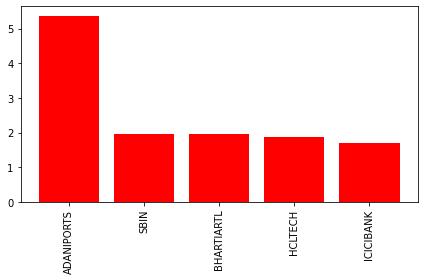

In [12]:
"""
festive_seastons (List<Tuple[3]>) -> A list of tuples wherein each tuple will be (festival_name (str), start_date(dd/mm/yyyy), end_date(dd/mm/yyyy))
Return a list of top 5 stocks corresponding to each season
"""
def problemThree(festive_season):
  dateList = seasonRange[festive_season]
  startDate = dateList[0]
  endDate = dateList[1]

  nifty50Df = Nifty50_df.withColumn('year', substring('Date', 0,4))
  nifty50Df = nifty50Df.withColumn('monthAndDay', substring('Date', 6,5))

  startDateData = nifty50Df[nifty50Df["monthAndDay"] == startDate]
  endDateData = nifty50Df[nifty50Df["monthAndDay"] == endDate]

  festivalData = startDateData.join(endDateData,(startDateData["year"] ==  endDateData["year"]) & (startDateData["Symbol"] ==  endDateData["Symbol"]) ,"inner").select(startDateData["year"],startDateData["Symbol"],startDateData["Open"].alias("festiveOpen"), endDateData["Close"].alias("festiveClose"))
  festivalData = festivalData.withColumn("profit", ((festivalData["festiveClose"] - festivalData["festiveOpen"])*100)/festivalData["festiveOpen"])

  festivalData = festivalData.groupBy("Symbol").agg( avg("profit").alias("avgProfit"))

  festivalData = festivalData.sort(desc("avgProfit"))

  festivalDataList = festivalData.take(5)

  symbol = []
  profit = []

  for i in range(len(festivalDataList)):
    symbol.append(festivalDataList[i][0])
    profit.append(festivalDataList[i][1])

  indices = np.arange(len(festivalDataList))
  plt.bar(indices, profit, color='r')
  plt.xticks(indices, symbol, rotation='vertical')
  plt.tight_layout()
  plt.show()

problemThree("Diwali")

##Problem 4. For a particular stock find out the most correlated other stock in the available list of stocks.

The Maximum co-related stock to the given input stock: SBIN is: ICICIBANK


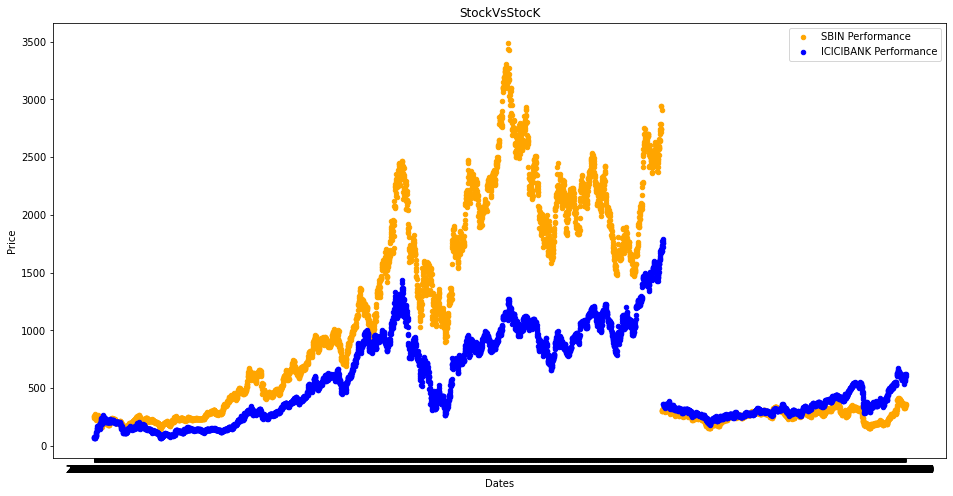

In [13]:
def problemFour(inputStock):

  stockAll = Nifty50_df.select('Symbol').distinct().collect()
  allStock = []
  for eachStock in stockAll:
    if eachStock.Symbol != inputStock:
      allStock.append(eachStock.Symbol)
  #print(allStock)

  AVG_RELATIVE_DIVERGENCE_DICT = {}

  inputStockData = Nifty50_df.filter(col("Symbol") == inputStock)
  minMaxInputStock = inputStockData.groupBy("Symbol").agg(sparkMin("Close").alias("inputRangeMin"), sparkMax("Close").alias("inputRangeMax"))
  inputStockData = inputStockData.join(minMaxInputStock,'Symbol', how="inner")
  inputStockData = inputStockData.withColumn("inputNormalizedClose",(inputStockData["Close"] - inputStockData["inputRangeMin"])*100 /(inputStockData["inputRangeMax"] - inputStockData["inputRangeMin"]))
  inputStockDataPdf = inputStockData.toPandas()

  for eachStock in allStock:
    eachStockData = Nifty50_df.filter(col("Symbol") == eachStock)
    minMaxEachStock = eachStockData.groupBy("Symbol").agg(sparkMin("Close").alias("rangeMin"), sparkMax("Close").alias("rangeMax"))
    eachStockData = eachStockData.join(minMaxEachStock,'Symbol', how="inner")
    eachStockData = eachStockData.withColumn("normalizedClose",(eachStockData["Close"] - eachStockData["rangeMin"])*100 /(eachStockData["rangeMax"] - eachStockData["rangeMin"]))
    eachStockData = eachStockData.join(inputStockData,eachStockData["Date"] ==  inputStockData["Date"],"inner").select(eachStockData["*"],inputStockData["inputNormalizedClose"])
    eachStockData = eachStockData.withColumn("dailyDivergance", abs(col("normalizedClose") - col("inputNormalizedClose")))
    avgDiverganceDf = eachStockData.groupBy("Symbol").agg(mean("dailyDivergance"))
    AVG_RELATIVE_DIVERGENCE_DICT.update({eachStock : avgDiverganceDf.collect()[0][1]})

  desiredStockDiv = min(AVG_RELATIVE_DIVERGENCE_DICT.values())
  desiredStock = ""

  for key,value in AVG_RELATIVE_DIVERGENCE_DICT.items():
    if value == desiredStockDiv:
      desiredStock = key

  print("The Maximum co-related stock to the given input stock: " + inputStock + " is: " + desiredStock)

  desiredStockData = Nifty50_df.filter(col("Symbol") == desiredStock)

  desiredStockDataPdf=desiredStockData.toPandas()
  desiredStockDataPdf=desiredStockDataPdf.set_index('Date')
  inputStockDataPdf=inputStockDataPdf.set_index('Date')

  plt.figure(figsize=(16,8))
  plt.scatter(inputStockDataPdf.index, inputStockDataPdf["Close"],color="orange",s=20,label=inputStock+" Performance")
  plt.scatter(desiredStockDataPdf.index, desiredStockDataPdf["Close"],color="blue",s=20,label=desiredStock+" Performance")
  plt.xlabel("Dates")
  plt.ylabel("Price")
  plt.title("StockVsStocK")
  plt.legend()
  plt.show()

problemFour("SBIN")

## Problem 5. How much value do we put at risk by investing in a particular stock.

In [16]:
"""
stock_to_invest (str) -> The symbol of the stock to invest in
"""

from pyspark.sql.functions import rank, col
from pyspark.sql.functions import col, isnan, when, trim
import pandas as pd



def problemFive(stock_to_invest,startDate , endDate):
  #.withColumn("Date", F.year(col("Date").cast("timestamp")))
  stock = stock_to_invest.withColumn("Open", col("Open").cast("Double"))
  #stockData = stock.where( stock["Date"].between(startDate,endDate)).cache()
  #stock = stock_to_invest.withColumn("Date", F.year(col("Date").cast("timestamp"))).withColumn("Open", col("Open").cast("Double"))
  stockData=stock
  
  #stock.printSchema()
  ValidData = stockData.where((col("Open").isNotNull()) & (col("Close").isNotNull()))
  #daily_return = ValidData.withColumn("daily_Return",((col("Close") - col("Prev Close"))*100)/col("Prev Close"))
  daily_return = ValidData.withColumn("daily_Return",(col("Close") - col("Open"))/col("Open")).cache()
  exp_stock = daily_return.groupBy("Symbol").agg(F.avg(daily_return.daily_Return).alias("mean"))
  sd_stock = daily_return.groupBy("Symbol").agg(F.stddev(daily_return.daily_Return).alias("stddev"))
  exp_sd_stock = exp_stock.join(sd_stock,on=["Symbol"])
  
  calculate_risk = exp_sd_stock.withColumn("Risk",F.when((col("mean") < 0) & (F.abs(col("mean")-col("stddev")) < 20),"LOSS and RISKY").when((col("mean") < 0) & (F.abs(col("mean")-col("stddev")) > 20), "HIGHLY RISKY").when((col("mean") > 0) & (F.abs(col("mean")-col("stddev")) < 20),"CONSITENTLY PROFITABLE").otherwise("HIGHLY VOLATILE")).where((col("mean")!= 0) & (col("stddev")!=0)).sort("mean",ascending=True).cache()
  window = Window.partitionBy(calculate_risk['Risk']).orderBy(calculate_risk['mean'].desc())

  groupTop5 = calculate_risk.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 5).sort("mean",ascending=False)
  
  answerList = calculate_risk.collect()

  answer_mean=[]
  answer_std=[]
  answer_symbol=[]
  answer=[]
  answer_Risk=[]

  for i in answerList:
    
    answer_mean.append(i["mean"])
    answer_std.append(i["stddev"])
    answer_symbol.append(i["Symbol"])
    answer_Risk.append(i["Risk"])
    answer.append([i["Symbol"],i["mean"],i["stddev"]])
  #plotGraph(answer_Risk,answer_mean,answer_std,answer_symbol)

  return calculate_risk,groupTop5,daily_return


def RiskForStock(stock,stockData):
  riskData = stockData.where(col("Symbol")==stock).show(10)
  return riskData

dataYear = problemFive(stock_df,'2010/01/01','2020/04/30')[0]
dailyreturn = problemFive(stock_df,'2010/01/01','2020/04/30')[2]
Symbol = "MRF"
RiskForStock(Symbol,dataYear)

import plotly.express as px
import pandas as pd

df = dailyreturn.where(col("Symbol")==Symbol).collect()

k=1
x=[]
y=[]

for i in df:
    if (k%30==0):
      x.append(i['Date'])
      y.append(i['daily_Return'])
    k=k+1

df1 = pd.DataFrame(dict(
    {'Date' : x,
    'Daily_Return' : y}
))
fig = px.line(df1, x="Date", y="Daily_Return", title='Daily Return')
fig.show()

+------+--------------------+--------------------+--------------+
|Symbol|                mean|              stddev|          Risk|
+------+--------------------+--------------------+--------------+
|   MRF|-0.00144788846723...|0.024481907525539887|LOSS and RISKY|
+------+--------------------+--------------------+--------------+



## Problem 6. A user wants to know the top 5 stocks to invest for a minimum 10% return on holding a stock for a quarter (Jan-Mar), (Apr-June), (July-Sep), (Oct-Dec)

In [17]:


def problemEight(stock_data,year):
  dataFormatted = stock_data.where(col("Date")[0:4]==year).withColumn("Date", col("Date").cast("Date"))
  valid_data = dataFormatted.where(col("Open").isNotNull() & col("Close").isNotNull() & col("Date").isNotNull())
  quarter_division = valid_data.withColumn("quarter", when((F.month(col("Date")).cast("int") == 1) | (F.month(col("Date")).cast("int") == 2) | (F.month(col("Date")).cast("int") == 3),1)
                                 .when((F.month(col("Date")).cast("int") == 4) | (F.month(col("Date")).cast("int") == 5) | (F.month(col("Date")).cast("int") == 6),2)
                                 .when((F.month(col("Date")).cast("int") == 7) | (F.month(col("Date")).cast("int") == 8) | (F.month(col("Date")).cast("int") == 9),3)
                                 .when((F.month(col("Date")).cast("int") == 10) | (F.month(col("Date")).cast("int") == 11) | (F.month(col("Date")).cast("int") == 12),4)
                                 .otherwise(1)).sort("quarter","Date").withColumn("Division",F.concat(col("Symbol"),col("quarter"))).cache()
  w = Window.partitionBy(quarter_division["Division"]).orderBy(quarter_division['Date'].desc())
  dfTop = quarter_division.withColumn("rn", F.row_number().over(w)).where(col("rn") == 1).drop("rn").withColumn("LastDate",col("Date")).withColumn("LastClose",col("Close"))

  w2 = Window.partitionBy(quarter_division["Division"]).orderBy(quarter_division['Date'])
  dfTop2 = quarter_division.withColumn("rn", F.row_number().over(w2)).where(col("rn") == 1).drop("rn").withColumn("FirstDate",col("Date")).withColumn("FirstOpen",col("Open"))

  finalJoin = dfTop.join(dfTop2,"Division").select(dfTop.Symbol,dfTop.quarter,"LastDate","FirstDate","FirstOpen","LastClose").cache()


  quarterlyReturn = finalJoin.withColumn("return",(col("LastClose") - col("FirstOpen"))*100/col("FirstOpen"))
  filteredData = quarterlyReturn.select("Symbol","return","quarter").groupBy("Symbol","quarter").avg("return")
  answerList = filteredData.where(col("avg(return)")>=10).sort("quarter","avg(return)",ascending=False).cache()

  window = Window.partitionBy(answerList['quarter']).orderBy(answerList['avg(return)'].desc())

  answer = answerList.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 10).sort("quarter","avg(return)",ascending=False)
  return answer

problemEight(stock_df,2012)

def ValuesQuarter(quarter):
  data = problemEight(stock_df,2012)
  answer = data.where(col("quarter") == quarter).collect()
  #answer = data.collect()
  return answer
data1 = ValuesQuarter(1)
data2 = ValuesQuarter(2)
data3 = ValuesQuarter(3)
data4 = ValuesQuarter(4)


import plotly
import plotly.express as px
import plotly.graph_objects as go



x=[]
y=[]
for d in data1:
    x.append(d['Symbol'])
    y.append(d['avg(return)'])

df1 = pd.DataFrame(dict(
    {'Symbol' : x,
    'Quarterly_Return' : y}
))
fig = px.bar(df1, x='Symbol', y='Quarterly_Return', title="1st quarter (Jan-Mar)",width=800, height=600)
fig.show()


x=[]
y=[]
for d in data2:
    x.append(d['Symbol'])
    y.append(d['avg(return)'])
df2 = pd.DataFrame(dict(
    {'Symbol' : x,
    'Quarterly_Return' : y}
))
fig = px.bar(df2, x='Symbol', y='Quarterly_Return', title="2nd quarter (Apr-Jun)",width=800, height=600)
fig.show()

x=[]
y=[]
for d in data3:
    x.append(d['Symbol'])
    y.append(d['avg(return)'])
df3 = pd.DataFrame(dict(
    {'Symbol' : x,
    'Quarterly_Return' : y}
))
fig = px.bar(df3, x='Symbol', y='Quarterly_Return', title="3rd quarter (Jul-Sept)",width=800, height=600)
fig.show()

x=[]
y=[]
for d in data4:
    x.append(d['Symbol'])
    y.append(d['avg(return)'])
df4 = pd.DataFrame(dict(
    {'Symbol' : x,
    'Quarterly_Return' : y}
))
fig = px.bar(df4, x='Symbol', y='Quarterly_Return', title="4th quarter (Oct-Dec)",width=800, height=600)
fig.show()

## Problem 7. Show the daily return of the stock on average in a particular time frame

-0.5832828282828285

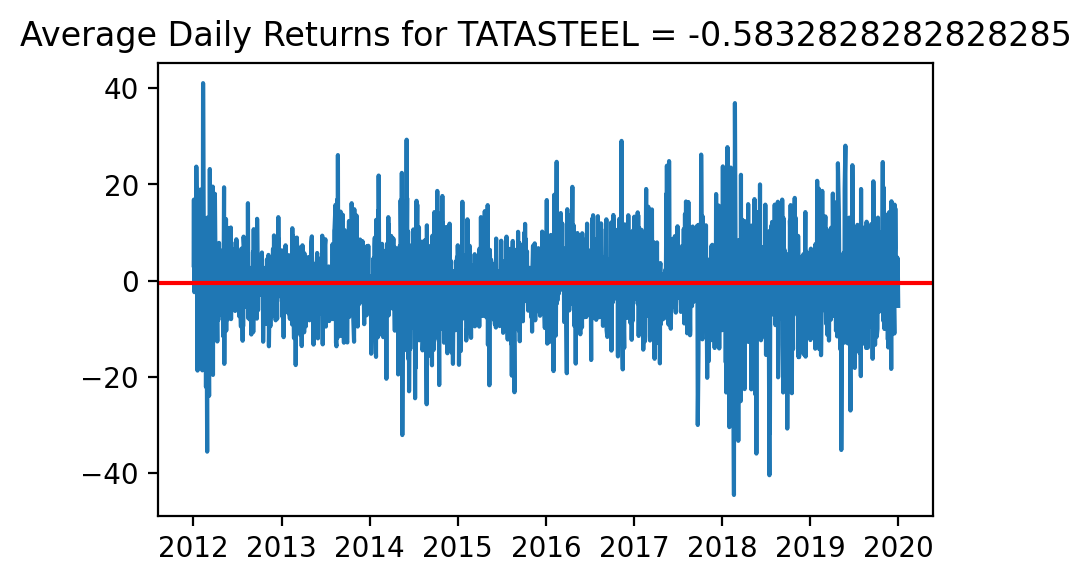

In [18]:
def problemSix(stocks_df, stock_to_invest, start_time, end_time):
  #Get the SCRIP from the user
  #start_time -> The starting time of the time frame
  #end_time -> The end time of the time frame
  #plot a graph for daily returns, x axis will be date, and y will be return on that date
  filtered_df = stocks_df.filter(stocks_df.Symbol == stock_to_invest).select(to_date(col("Date")).alias("Date"), col("Symbol"), col("Open"), col("Close")).filter(stocks_df.Date >= start_time).filter(stocks_df.Date <= end_time)
  daily_returns_df = filtered_df.withColumn("Daily_Returns", filtered_df["Close"] - filtered_df["Open"])
  graph_data = daily_returns_df.collect()
  #graph plot
  dates = []
  daily_returns = []
  for row in graph_data:
    dates.append(row['Date'])
    daily_returns.append(row['Daily_Returns'])
  #end graph plot
  answer = daily_returns_df.select("Date", "Symbol", "Daily_Returns").groupBy("Symbol").avg("Daily_Returns").withColumnRenamed("avg(Daily_Returns)", "Avg_Daily_Returns").collect()
  figure(figsize=(5,3), dpi=200)
  plt.title("Average Daily Returns for " + stock_to_invest + " = " + str(answer[0]['Avg_Daily_Returns']))
  plt.plot(dates, daily_returns, label='Daily Return (close - open)')
  plt.axhline(y=answer[0]['Avg_Daily_Returns'], color='r', linestyle='-')
  return answer[0]['Avg_Daily_Returns']
problemSix(__STOCKS_DF__, "TATASTEEL", "2012-01-01", "2020-01-01")

## Problem 8. Show the moving average of the various stocks in a particular time frame.

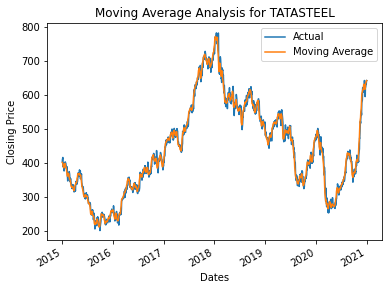

In [19]:
STOCK_NAME = "TATASTEEL"
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
def problemSeven(stocks_df, stocks, start_time, end_time, window_length):
  df = stocks_df.filter(stocks_df.Symbol == stocks).select(to_date(col("Date")).alias("Date"), col("Symbol"), col("Close")).filter(stocks_df.Date >= start_time).filter(stocks_df.Date <= end_time)
  w = (Window().orderBy(col("Date").asc()).rowsBetween(Window.currentRow, window_length))
  df = df.withColumn('rolling_average', avg("Close").over(w))
  return df.collect()
data = problemSeven(__STOCKS_DF__, STOCK_NAME, "2015-01-01", "2021-01-01", 5);
dates = []
rolling_average = []
close_prices = []
for row in data:
    dates.append(row['Date'])
    rolling_average.append(row['rolling_average'])
    close_prices.append(row['Close'])
plt.plot(dates, close_prices, label='Actual')
plt.plot(dates, rolling_average, label='Moving Average')
plt.xlabel("Dates")
plt.ylabel("Closing Price")
plt.legend()
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.title("Moving Average Analysis for " + STOCK_NAME)
for label in plt.gca().get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

In [20]:
#Twitter sentiment analysis Code

params = {
          'query': '(reliance) (lang:en)',
          'max_results': '100',
          'tweet.fields': 'created_at,lang'
          }

BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAExoWQEAAAAAkfB0OGoSb9dUd5c8rNEFbHyhgwU%3DnQKcP6jsareZzqXPm5tMBrLNWvi0BilFHKOeNrCh5HRVRW1wOW'
'''response = requests.get(
    'https://api.twitter.com/2/tweets/search/recent',
    params=params,
    headers={
        'authorization': 'Bearer '+ BEARER_TOKEN
})'''


tweetList = []

#Regex for cleaning tweet text
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
reliance = re.compile(r"(?i)@Reliance(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")
  

dtformat = '%Y-%m-%dT%H:%M:%SZ'

now = datetime.now() - timedelta(seconds=10)  #Get the current datetime
endTime = now

startTime = endTime - timedelta(days=8)  #StartTime would be number of days mentioned before the end time
endTime = endTime.strftime(dtformat)  #Convert now datetime to format for API

iteration = 0
while True:
    if datetime.strptime(endTime, dtformat) < startTime:
        #Break the loop if endTime reaches startTime
        break

    pre60 = time_travel(endTime, 60)  #Get 1 hour before endTime

    #Assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = endTime
    response = requests.get(
      'https://api.twitter.com/2/tweets/search/recent',
      params=params,
      headers={
        'authorization': 'Bearer '+ BEARER_TOKEN
      })
    iteration = iteration + 1
    if iteration % 288 == 0:
      time.sleep(15)
    endTime = pre60  #Move the window 1 hour earlier

    if "data" in response.json():
      for tweet in response.json()['data']:
        row = getData(tweet)
        tweetList.append(row)

tweetDf = spark.createDataFrame(Row(**x) for x in tweetList)
tweetDf = tweetDf.withColumn('text', tweetUDF(col('text')))
tweetDf.show(5)
tweetDf.cache()



+-------------------+--------------------+--------------------+
|                 id|          created_at|                text|
+-------------------+--------------------+--------------------+
|1469352549593788417|2021-12-10T17:05:...|RT : Interesting....|
|1469352546665967625|2021-12-10T17:05:...|Rupee - Dec 10, 2...|
|1469352403115945988|2021-12-10T17:04:...|RT : Flying witho...|
|1469352243291832322|2021-12-10T17:04:...|RT : #Indraprasth...|
|1469352219225083908|2021-12-10T17:04:...|RT : Flying witho...|
+-------------------+--------------------+--------------------+
only showing top 5 rows



DataFrame[id: string, created_at: string, text: string]

In [21]:
#Function to get the Predicted Sentiment Score
def predictSentimentScore(tweet):
  sentence = flair.data.Sentence(tweet)
  sentiment_model.predict(sentence)
  return sentence.labels[0].score

#Function to get the Predicted Sentiment Value
def predictSentimentValue(tweet):
  sentence = flair.data.Sentence(tweet)
  sentiment_model.predict(sentence)
  return sentence.labels[0].value

predictScoreUDF = udf(lambda z:predictSentimentScore(z),DoubleType())
predictValueUDF = udf(lambda z:predictSentimentValue(z),StringType())

tweetDf = tweetDf.withColumn('probability', predictScoreUDF(col('text'))).withColumn('sentiment', predictValueUDF(col('text')))
tweetDf = tweetDf.withColumn('date', substring('created_at', 1,10))
tweetDf.show(5)
tweetDf.cache()

+-------------------+--------------------+--------------------+------------------+---------+----------+
|                 id|          created_at|                text|       probability|sentiment|      date|
+-------------------+--------------------+--------------------+------------------+---------+----------+
|1469352549593788417|2021-12-10T17:05:...|RT : Interesting....|0.9954772591590881| NEGATIVE|2021-12-10|
|1469352546665967625|2021-12-10T17:05:...|Rupee - Dec 10, 2...|0.8381022214889526| NEGATIVE|2021-12-10|
|1469352403115945988|2021-12-10T17:04:...|RT : Flying witho...|0.8545066714286804| POSITIVE|2021-12-10|
|1469352243291832322|2021-12-10T17:04:...|RT : #Indraprasth...|0.7850717902183533| POSITIVE|2021-12-10|
|1469352219225083908|2021-12-10T17:04:...|RT : Flying witho...|0.8545066714286804| POSITIVE|2021-12-10|
+-------------------+--------------------+--------------------+------------------+---------+----------+
only showing top 5 rows



DataFrame[id: string, created_at: string, text: string, probability: double, sentiment: string, date: string]

In [22]:
#Grouping the Data Frame by date and Sentiment value to get average probability and tweet count in a single day based on sentiment
avgTweetDf = tweetDf.groupBy("date", "sentiment").agg(avg("probability").alias("avgProbability"), count("id").alias("tweetCount"))
avgTweetDf = avgTweetDf.select(date_format(col("date"),"MMM dd, yyyy").alias("Date"), col("avgProbability"), col("tweetCount"), col("sentiment"))
avgTweetDf.show(14)
avgTweetDf.cache()

+------------+------------------+----------+---------+
|        Date|    avgProbability|tweetCount|sentiment|
+------------+------------------+----------+---------+
|Dec 10, 2021|0.8999399024557014|       521| POSITIVE|
|Dec 05, 2021|0.9571385880867085|      1430| NEGATIVE|
|Dec 04, 2021|0.9177351395506718|       913| POSITIVE|
|Dec 08, 2021|0.9480828767498151|      1511| NEGATIVE|
|Dec 06, 2021|0.9053890700639691|      1067| POSITIVE|
|Dec 08, 2021|0.9140621703774992|       879| POSITIVE|
|Dec 09, 2021|0.9369858534125223|      1549| NEGATIVE|
|Dec 10, 2021|0.9398105151788636|      1145| NEGATIVE|
|Dec 09, 2021|0.9130130250262313|       846| POSITIVE|
|Dec 04, 2021| 0.937269993600616|      1414| NEGATIVE|
|Dec 07, 2021|0.9349233272008538|      1492| NEGATIVE|
|Dec 03, 2021|0.9103639418152487|       157| POSITIVE|
|Dec 07, 2021|0.8864965403040206|       899| POSITIVE|
|Dec 03, 2021|0.9372182617199074|       412| NEGATIVE|
+------------+------------------+----------+---------+
only showi

DataFrame[Date: string, avgProbability: double, tweetCount: bigint, sentiment: string]

In [23]:
#Dividing the Data Frame w.r.t Positive and Negative sentiment
negTweetDf = avgTweetDf.filter(col("sentiment").like("%NEGATIVE%"))
negTweetDf = negTweetDf.withColumnRenamed("avgProbability","avgNegativeProbability")
negTweetDf = negTweetDf.withColumnRenamed("tweetCount","negativeTweetCount")
negTweetDf = negTweetDf.drop("sentiment")

posTweetDf = avgTweetDf.filter(col("sentiment").like("%POSITIVE%"))
posTweetDf = posTweetDf.withColumnRenamed("avgProbability","avgPositiveProbability")
posTweetDf = posTweetDf.withColumnRenamed("tweetCount","positiveTweetCount")
posTweetDf = posTweetDf.drop("sentiment")

In [24]:
#Web Scraping Reliance stock Data

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}

url = "https://in.investing.com/equities/reliance-industries-historical-data"
r = Request(url, headers=headers)
try:
  page = urlopen(r)
except:
 print("Error")

soup = bs4.BeautifulSoup(page,'html.parser')

date = soup.find_all('td',{'class': 'col-rowDate'})#.find('span').text
allDates = [data.text.replace("\n", "") for data in date]

lastClose = soup.find_all('td',{'class': 'col-last_close'})
allClose = [data.text.replace("\n", "") for data in lastClose]

open = soup.find_all('td',{'class': 'col-last_open'})
allOpen = [data.text.replace("\n", "") for data in open]

high = soup.find_all('td',{'class': 'col-last_max'})
allHigh = [data.text.replace("\n", "") for data in high]

low = soup.find_all('td',{'class': 'col-last_min'})
allLow = [data.text.replace("\n", "") for data in low]

change = soup.find_all('td',{'class': 'col-change_percent'})
allChange = [data.text.replace("\n", "")[:-1] for data in change]

relianceDf = spark.createDataFrame(zip(allDates, allClose, allOpen, allHigh, allLow, allChange), schema=['Date', 'Price', 'Open', 'High', 'Low', 'ChangePerc'])

relianceDf.show()

+------------+--------+--------+--------+--------+----------+
|        Date|   Price|    Open|    High|     Low|ChangePerc|
+------------+--------+--------+--------+--------+----------+
|Dec 10, 2021|2,458.95|2,440.25|2,466.00|2,430.35|      0.10|
|Dec 09, 2021|2,456.45|2,435.00|2,474.90|2,425.00|      1.59|
|Dec 08, 2021|2,418.10|2,424.10|2,431.80|2,406.30|      1.52|
|Dec 07, 2021|2,381.85|2,376.15|2,404.00|2,360.00|      0.81|
|Dec 06, 2021|2,362.60|2,416.00|2,425.00|2,357.15|     -1.90|
|Dec 03, 2021|2,408.25|2,498.40|2,498.50|2,400.00|     -3.00|
|Dec 02, 2021|2,482.85|2,469.70|2,496.20|2,461.60|      0.64|
|Dec 01, 2021|2,467.00|2,433.00|2,474.00|2,425.10|      2.56|
|Nov 30, 2021|2,405.40|2,468.00|2,475.90|2,388.85|     -1.48|
|Nov 29, 2021|2,441.50|2,439.10|2,500.00|2,399.10|      1.20|
|Nov 26, 2021|2,412.60|2,467.80|2,477.60|2,401.50|     -3.22|
|Nov 25, 2021|2,492.95|2,373.00|2,502.00|2,357.15|      6.02|
|Nov 24, 2021|2,351.40|2,380.00|2,409.90|2,343.55|     -1.44|
|Nov 23,

In [25]:
#Joining the web scraped Reliance stock data frame with already created POSITIVE and NEGATIVE data frames 
fullDf = relianceDf.join(posTweetDf,'Date', how="inner")
fullDf = fullDf.join(negTweetDf,'Date', how="inner")
fullDf = fullDf.sort("Date")
fullDf.show()
fullDf.cache()

+------------+--------+--------+--------+--------+----------+----------------------+------------------+----------------------+------------------+
|        Date|   Price|    Open|    High|     Low|ChangePerc|avgPositiveProbability|positiveTweetCount|avgNegativeProbability|negativeTweetCount|
+------------+--------+--------+--------+--------+----------+----------------------+------------------+----------------------+------------------+
|Dec 03, 2021|2,408.25|2,498.40|2,498.50|2,400.00|     -3.00|    0.9103639418152487|               157|    0.9372182617199074|               412|
|Dec 06, 2021|2,362.60|2,416.00|2,425.00|2,357.15|     -1.90|    0.9053890700639691|              1067|    0.9508849513034416|              1273|
|Dec 07, 2021|2,381.85|2,376.15|2,404.00|2,360.00|      0.81|    0.8864965403040206|               899|    0.9349233272008538|              1492|
|Dec 08, 2021|2,418.10|2,424.10|2,431.80|2,406.30|      1.52|    0.9140621703774992|               879|    0.948082876749815

DataFrame[Date: string, Price: string, Open: string, High: string, Low: string, ChangePerc: string, avgPositiveProbability: double, positiveTweetCount: bigint, avgNegativeProbability: double, negativeTweetCount: bigint]

In [26]:
dateList = []
priceList = []
posTweetCountList = []
negTweetCountList = []
avgPositiveProbabilityList = []
avgNegativeProbabilityList = []

for row in fullDf.collect():
  dateList.append(row.Date)
  priceList.append(row.Price)
  posTweetCountList.append(row.positiveTweetCount)
  negTweetCountList.append(row.negativeTweetCount)
  avgPositiveProbabilityList.append(row.avgPositiveProbability)
  avgNegativeProbabilityList.append(row.avgNegativeProbability)

priceList = [float(s.replace(",", "")) for s in priceList]

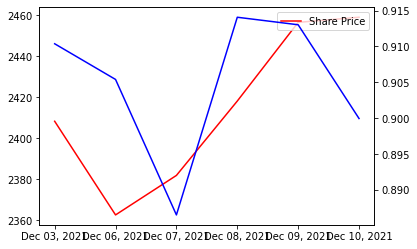

In [27]:
#Plotting Graph of the observed Data
fig = plt.figure()
ax = fig.add_subplot(111)
X_axis = np.arange(len(dateList))
ax.plot(dateList,priceList, color='red', label = 'Share Price')
ax.legend(loc='upper right')

axB = ax.twinx()
axB.plot(dateList,avgPositiveProbabilityList, color='blue', label = 'Net Positive Sentiment')
plt.show()


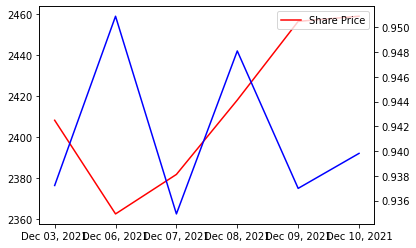

In [28]:
#Plotting Graph of the observed Data
fig = plt.figure()
ax = fig.add_subplot(111)
X_axis = np.arange(len(dateList))
ax.plot(dateList,priceList, color='red', label = 'Share Price')
ax.legend(loc='upper right')

axB = ax.twinx()
axB.plot(dateList,avgNegativeProbabilityList, color='blue', label = 'Net Positive Sentiment')
plt.show()